In [1]:
import argparse
import os
import uuid
from IPython.core.magic import register_cell_magic
from IPython.display import SVG

@register_cell_magic
def plantuml(line, cell):
    """Generate and display a figure using Plantuml.
    Usage:
      %java -jar plantuml.jar -tsvg filname
    """

    parser = argparse.ArgumentParser()
    parser.add_argument("-n", "--name", type=str, default='puml_drawing',
                        help="<name>.svg and <name>.pdf after rendering")
    parser.add_argument("-t", "--tempname", type=str, default=None,
                        help="persist as <temp-name>.uml after rendering")
    parser.add_argument("-d", "--directory", default=None,
                        help="directory to save renders in")
    args = parser.parse_args(line.split() if line else "")

    retain = args.tempname is not None
    if args.directory :
        directory = args.directory + "/"
    else:
        directory = ""
    temp_name = args.tempname or str(uuid.uuid4())
    base_name = args.name

    uml_path = directory + base_name + ".uml"
    svg_path = directory + base_name + ".svg"
    pdf_path = directory + base_name + ".pdf"

    with open(uml_path, 'w') as fp:
        fp.write(cell)

    try:
        os.system("java -jar plantuml.jar -tsvg %s" % uml_path)
        os.system("inkscape --file=%s --export-area-drawing --without-gui --export-pdf=%s" % (svg_path, pdf_path))
        return SVG(filename=svg_path)
    finally:
        if not retain:
            os.unlink(uml_path)

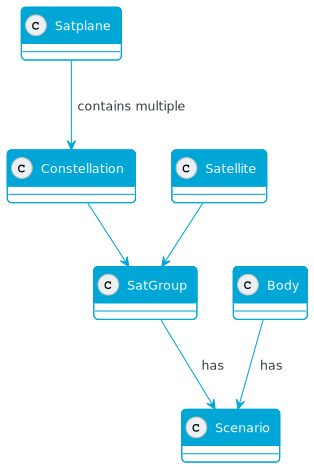

In [2]:
%%plantuml -t test -d D:/git/thesis_report_ae/figures

@startuml
!include D:\git\puml-themes\themes\tudelft\puml-theme-tudelft-outline.puml

class Scenario

class SatGroup

class Body

class Constellation

class Satellite

class Satplane

Satplane --> Constellation : contains multiple
Constellation --> SatGroup
Satellite --> SatGroup

SatGroup --> Scenario : has
Body --> Scenario : has

@enduml

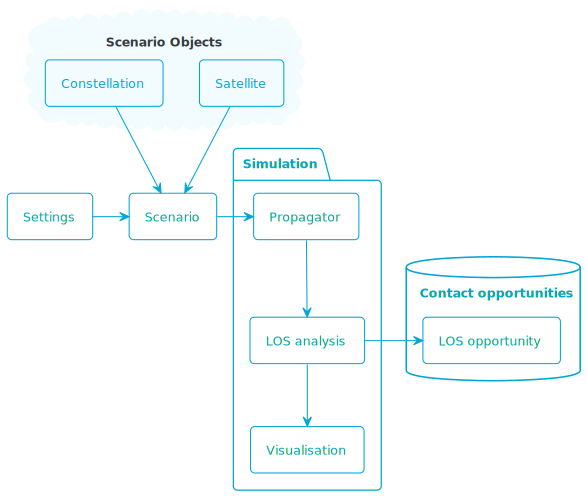

In [3]:
%%plantuml -n hermes_overview -d D:/git/thesis_report_ae/figures

@startuml
!include D:\git\puml-themes\themes\tudelft\puml-theme-tudelft-outline.puml

skinparam componentStyle rectangle


    package "Simulation" {
        [Propagator] -d-> [LOS analysis]
        [LOS analysis] -d-> [Visualisation]
    }

    [Scenario] -> [Propagator]
    [Settings] -r-> [Scenario]

    cloud "Scenario Objects" {
        [Satellite] --> [Scenario]
        [Constellation] --> [Scenario]
    }

    database "Contact opportunities" {
        [LOS opportunity]
    }
    [LOS analysis] -r-> [LOS opportunity]

@enduml

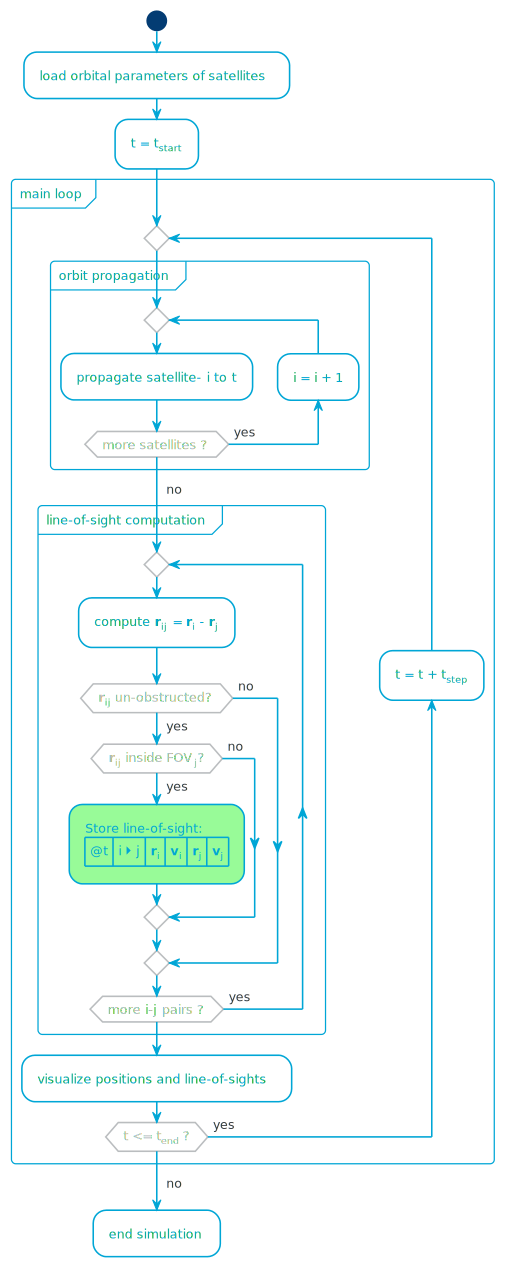

In [31]:
%%plantuml -n hermes_operation -d D:/git/thesis_report_ae/figures

@startuml
!include D:\git\puml-themes\themes\tudelft\puml-theme-tudelft-outline.puml
!pragma useVerticalIf on

start
:load orbital parameters of satellites;
://t = t<sub>start</sub>//;
partition "main loop" {
repeat
    partition "orbit propagation" {
        repeat
            :propagate satellite-//i// to //t//;
        backward://i = i + 1//;
        repeat while (more satellites ?) is (yes)
        -> no;
    }
    partition "line-of-sight computation" {
        repeat
            :compute //**r**<sub>ij</sub> = **r**<sub>i</sub> - **r**<sub>j</sub>//;
        if (**r**<sub>ij</sub> un-obstructed?) then (yes)
            if (**r**<sub>ij</sub> inside FOV<sub>j</sub>?) then (yes)
                #palegreen:Store line-of-sight:
                |@t|i <&caret-right>j|**r**<sub>i</sub>|**v**<sub>i</sub>|**r**<sub>j</sub>|**v**<sub>j</sub>|;
            else (no)
            endif
        else (no)
        endif


        repeat while (more //i-j// pairs ?) is (yes)
    }

:visualize positions and line-of-sights;
backward://t = t + t<sub>step</sub>//;
repeat while (//t <= t<sub>end</sub>// ?) is (yes)


}
-> no;
:end simulation;
@enduml


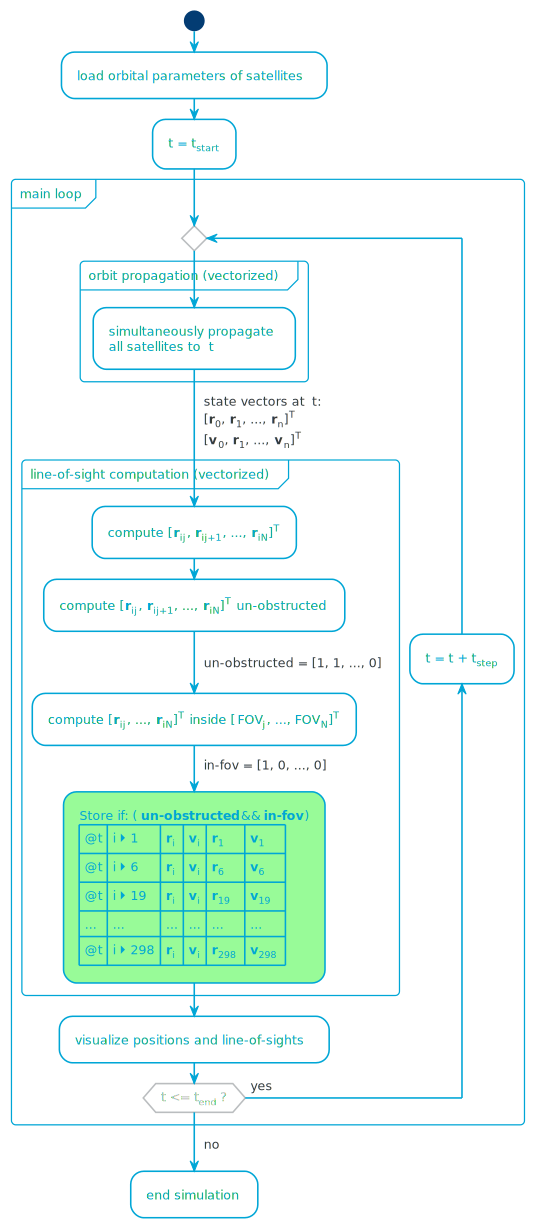

In [60]:
%%plantuml -n hermes_operation_vectorized -d D:/git/thesis_report_ae/figures

@startuml
!include D:\git\puml-themes\themes\tudelft\puml-theme-tudelft-outline.puml
!pragma useVerticalIf on

start
:load orbital parameters of satellites;
://t = t<sub>start</sub>//;
partition "main loop" {
repeat
    partition "orbit propagation (vectorized)" {
        :simultaneously propagate\nall satellites to //t//;
    }
    -> state vectors at //t//:
    [//**r**<sub>0</sub>, **r**<sub>1</sub>, ..., **r**<sub>n</sub>//]<sup>T</sup>
    [//**v**<sub>0</sub>, **r**<sub>1</sub>, ..., **v**<sub>n</sub>//]<sup>T</sup>;

    partition "line-of-sight computation (vectorized)" {
        :compute [//**r**<sub>ij</sub>, **r**<sub>ij+1</sub>, ..., **r**<sub>iN</sub>//]<sup>T</sup>;
        :compute [//**r**<sub>ij</sub>, **r**<sub>ij+1</sub>, ..., **r**<sub>iN</sub>//]<sup>T</sup> un-obstructed;
        -> un-obstructed = [1, 1, ..., 0];
        :compute [//**r**<sub>ij</sub>, ..., **r**<sub>iN</sub>//]<sup>T</sup> inside [//FOV<sub>j</sub>, ..., FOV<sub>N</sub>//]<sup>T</sup>;
        -> in-fov = [1, 0, ..., 0];
        #palegreen:Store if: (**un-obstructed** && **in-fov**)
        |@t|i <&caret-right>1|**r**<sub>i</sub>|**v**<sub>i</sub>|**r**<sub>1</sub>|**v**<sub>1</sub>|
        |@t|i <&caret-right>6|**r**<sub>i</sub>|**v**<sub>i</sub>|**r**<sub>6</sub>|**v**<sub>6</sub>|
        |@t|i <&caret-right>19|**r**<sub>i</sub>|**v**<sub>i</sub>|**r**<sub>19</sub>|**v**<sub>19</sub>|
        |...|...|...|...|...|...|
        |@t|i <&caret-right>298|**r**<sub>i</sub>|**v**<sub>i</sub>|**r**<sub>298</sub>|**v**<sub>298</sub>|;
    }

:visualize positions and line-of-sights;
backward://t = t + t<sub>step</sub>//;
repeat while (//t <= t<sub>end</sub>// ?) is (yes)


}
-> no;
:end simulation;
@enduml
